In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Get Data + Create Dataloaders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/asl_dataset'

images = []
labels = []

dataset = os.listdir(path)

for folder in dataset:
    subpath = os.path.join(path, folder)
    imgs = os.listdir(subpath)
    label = ord(folder)

    if label < 58:
      label -= 48
    else:
      label -= 87
    # Iterate through images in each letter
    for img in imgs:
        img_path = os.path.join(subpath, img)
        images.append(Image.open(img_path))
        labels.append(label)
    print(folder)

2
7
8
4
5
0
3
9
6
1
e
c
j
i
d
g
h
b
a
f
t
p
r
l
m
k
n
o
q
s
u
y
w
z
x
v


In [ ]:
#pil_images_train = [Image.fromarray(image) for image in images]
x_train = []
y_train = []
x_test = []
y_test= []
for i in range(len(images)):
  if(i % 70 < 56):
    x_train.append(images[i])
    y_train.append(labels[i])
  else:
    x_test.append(images[i])
    y_test.append(labels[i])

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match ResNet input size
    transforms.ToTensor(),  # Normalization
])

y_train = torch.Tensor(y_train)
y_test = torch.Tensor(y_test)

transformed_train = torch.stack([transform(image.convert('L')) for image in x_train])
train_dataset = torch.utils.data.TensorDataset(transformed_train, y_train)

transformed_test = torch.stack([transform(image.convert('L')) for image in x_test])
test_dataset = torch.utils.data.TensorDataset(transformed_test, y_test)

NameError: name 'images' is not defined

tensor(27.)
torch.Size([1, 224, 224])


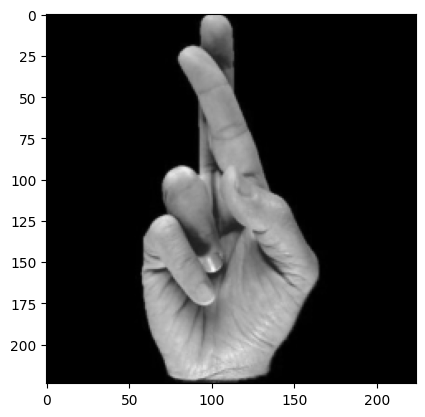

In [ ]:
# Code to display images
images= train_dataset[1238][0]
print(train_dataset[1238][1])
print(images.shape)
image = images.permute(1,2,0)
#image = image/2 + 0.5
plt.imshow(image, cmap='gray')

In [ ]:
testpath = '/content/drive/MyDrive/testset.pt'
trainpath = '/content/drive/MyDrive/trainset.pt'

train_dataset = torch.load(trainpath)
test_dataset = torch.load(testpath)
batch_size_train , batch_size_test = 10, 100
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size= batch_size_train, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False)

'''
from google.colab import files
torch.save(train_dataset, 'trainset.pt')
torch.save(test_dataset, 'testset.pt')
# download checkpoint file
files.download('trainset.pt')
files.download('testset.pt')
'''

"\nfrom google.colab import files\ntorch.save(train_dataset, 'trainset.pt')\ntorch.save(test_dataset, 'testset.pt')\n# download checkpoint file\nfiles.download('trainset.pt')\nfiles.download('testset.pt')\n"

In [ ]:
batch_idx, (images, _) =  next(enumerate(train_loader))

print(images.shape)

torch.Size([10, 1, 224, 224])


Model

In [ ]:
def vae_loss(output, mu, log_var, images):
  recon_loss = []
  KL_loss = []

  recon_loss = F.binary_cross_entropy(output, images, reduction = 'sum')

  var = torch.exp(log_var)
  KL_loss = -0.5 * torch.sum((1 + log_var - mu**2 - var))
  return recon_loss, KL_loss

In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class our_VAE(nn.Module):
  def __init__(self, latent_feature = 32):
    super(our_VAE, self).__init__()

    self.latent_feature = latent_feature

    # encoder
    self.en_fc1 = nn.Linear(224 * 224 , 3584)
    self.en_fc2 = nn.Linear(3584, latent_feature)
    self.en_fc3 = nn.Linear(3584, latent_feature)

    # decoder
    self.de_fc1 = nn.Linear(latent_feature, 3584)
    self.de_fc2 = nn.Linear(3584, 224 * 224)


  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5 * log_var)
    sample = torch.randn(std.size())
    sample = sample.to(device)
    sample = mu + std * sample
    return sample

  def encoder(self, x): #take input distribution, compute the reparametrization.

    x = torch.flatten(x, start_dim=1)
    x = F.relu(self.en_fc1(x))
    mu =  self.en_fc2(x)
    log_var = self.en_fc3(x)
    mu = mu.to(device)
    log_var = log_var.to(device)
    z = self.reparameterize(mu, log_var)

    return mu, log_var, z

  def decoder(self, z): #get output given latent samples

    x = F.relu(self.de_fc1(z))
    x = torch.sigmoid(self.de_fc2(x))
    x = x.reshape((-1, 1, 224, 224))
    return x

  def forward(self, x):
    mu, log_var, z = self.encoder(x)
    mu = mu.to(device)
    log_var = log_var.to(device)
    z = z.to(device)
    x = self.decoder(z)
    return x, mu, log_var

Training

In [ ]:
# Training code
def train(epoch, device, quiet=False):

  VAE.train() # we need to set the mode for our model

  for batch_idx, (images, _) in enumerate(train_loader): # Note that we do not need the labels
    images = images.to(device)
    optimizer.zero_grad()
    output, mu, log_var = VAE(images)
    bce, kld = vae_loss(output, mu, log_var, images) # Here is a typical loss function (Mean square error)
    loss = bce + kld
    loss.backward()
    optimizer.step()

    if batch_idx % 10 == 0: # We record our output every 10 batches
      bce_losses.append(bce/batch_size_train)
      kld_losses.append(kld/batch_size_train)
      train_losses.append(loss.item()/batch_size_train) # item() is to get the value of the tensor directly
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
    if batch_idx % 1000 == 0 and not quiet: # We visulize our output every 100 batches
      print(f'Epoch {epoch}: [{batch_idx*len(images)}/{len(train_loader.dataset)}] Loss: {loss.item()/batch_size_train}')

# Testing code
def test(epoch, device, quiet=False):

  VAE.eval() # we need to set the mode for our model

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for images, _ in test_loader:
      images = images.to(device)
      output, mu, log_var = VAE(images)
      bce, kld = vae_loss(output, mu, log_var, images)
      test_loss += bce+kld
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  test_counter.append(len(train_loader.dataset)*epoch)

  if not quiet:
    print(f'Test result on epoch {epoch}: Avg loss is {test_loss}')

# Running train and test
import torch.optim as optim

VAE = our_VAE().to(device)
optimizer = optim.Adam(VAE.parameters())#, lr=1e-3)

train_losses = []
train_counter = []
bce_losses = []
kld_losses = []
test_losses = []
test_counter = []
max_epoch = 20

for epoch in range(1, max_epoch+1):
  train(epoch, device=device)
  if(epoch % 5 == 0):
    test(epoch, device=device)

Epoch 1: [0/2016] Loss: 35117.08125
Epoch 2: [0/2016] Loss: 14869.528125
Epoch 3: [0/2016] Loss: 15358.9734375
Epoch 4: [0/2016] Loss: 13586.60625
Epoch 5: [0/2016] Loss: 14285.1734375
Test result on epoch 5: Avg loss is 14799.298828125
Epoch 6: [0/2016] Loss: 13124.44375
Epoch 7: [0/2016] Loss: 13590.34375
Epoch 8: [0/2016] Loss: 12534.565625
Epoch 9: [0/2016] Loss: 13013.6859375
Epoch 10: [0/2016] Loss: 11455.9828125
Test result on epoch 10: Avg loss is 14494.705078125
Epoch 11: [0/2016] Loss: 14769.3046875
Epoch 12: [0/2016] Loss: 12403.1234375
Epoch 13: [0/2016] Loss: 11700.3625
Epoch 14: [0/2016] Loss: 14861.434375
Epoch 15: [0/2016] Loss: 12879.1765625
Test result on epoch 15: Avg loss is 14508.232421875
Epoch 16: [0/2016] Loss: 14155.159375
Epoch 17: [0/2016] Loss: 12965.2921875
Epoch 18: [0/2016] Loss: 12728.49375
Epoch 19: [0/2016] Loss: 13402.825
Epoch 20: [0/2016] Loss: 13398.440625
Test result on epoch 20: Avg loss is 14468.53125


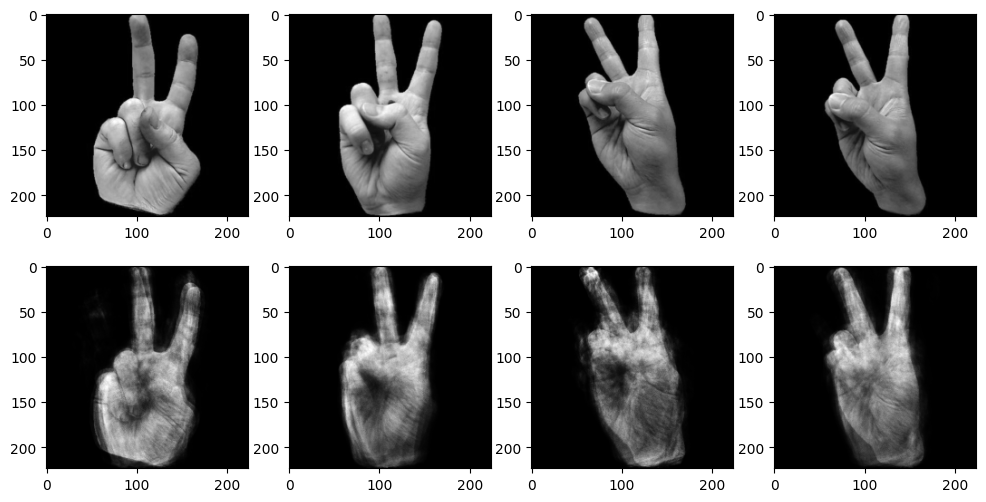

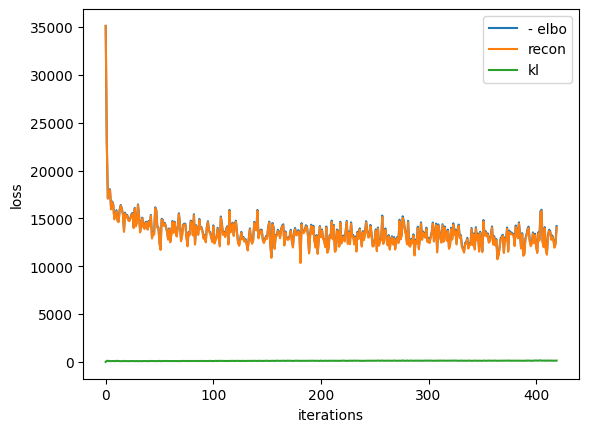

In [ ]:
# Visualization code
import matplotlib.pyplot as plt

batch_idx, (images, _) = next(enumerate(test_loader))
images = images.to(device)
VAE = VAE
output = VAE(images)[0].detach().cpu()
images = images.cpu()


fig, ax = plt.subplots(2,4)
fig.set_size_inches(12,6)

for idx in range(4):
  ax[0,idx].imshow(images[idx][0], cmap='gray')
  ax[1,idx].imshow(output[idx][0], cmap='gray')

fig.show()

plt.figure()
plt.plot(train_losses,label = '- elbo')
plt.plot([i.item() for i in bce_losses],label = 'recon')
plt.plot([i.item() for i in kld_losses],label = 'kl')
plt.xlabel('iterations')
plt.ylabel('loss')
plt.legend()
plt.show()

VAE With labels

In [ ]:
# Define label-to-embedding model
class LabelToEmbedding(nn.Module):
    def __init__(self, latent_feature):
        super(LabelToEmbedding, self).__init__()
        self.fc = nn.Linear(36, latent_feature)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return x


# Initialize label-to-embedding model
model_label_to_embedding = LabelToEmbedding(latent_feature=32).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean squared error loss
optimizer = optim.Adam(model_label_to_embedding.parameters())

# Use encoder to generate embeddings
def get_embeddings(loader, encoder):
    embeddings = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            _, _, z = encoder(images)
            if labels.dtype != torch.long:  # Convert labels to index tensor if not already
                labels = labels.type(torch.long)
            one_hot_labels = F.one_hot(labels, num_classes=36).float() # One-hot encode labels
            embeddings.append((z, one_hot_labels))
    return embeddings

train_embeddings = get_embeddings(train_loader, VAE.encoder)
test_embeddings = get_embeddings(test_loader, VAE.encoder)

In [ ]:
# Training label-to-embedding model
for epoch in range(60):
    for embeddings, one_hot_labels in train_embeddings:
        optimizer.zero_grad()
        outputs = model_label_to_embedding(one_hot_labels) # Use one-hot encoded labels
        loss = criterion(outputs, embeddings)
        loss.backward()
        optimizer.step()
    if(epoch % 10 == 0):
      print(f'Epoch [{epoch+1}/{100}], Loss: {loss.item():.4f}')


Epoch [1/100], Loss: 4.9273
Epoch [11/100], Loss: 3.6363
Epoch [21/100], Loss: 3.3391
Epoch [31/100], Loss: 3.2066
Epoch [41/100], Loss: 3.1740
Epoch [51/100], Loss: 3.1659


In [ ]:
def generate_images_from_labels(labels, model_label_to_embedding, decoder):
    if labels.dtype != torch.long:  # Convert labels to index tensor if not already
                labels = labels.type(torch.long)
    one_hot_labels = F.one_hot(labels, num_classes=36).float() # One-hot encode labels
    predicted_embeddings = model_label_to_embedding(one_hot_labels)
    decoded_images = decoder(predicted_embeddings)
    return decoded_images


Enter String:signme


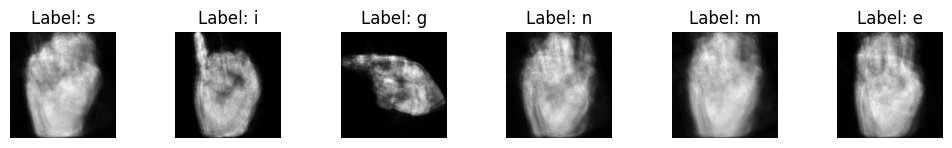

Animated GIF saved at: animation.gif


In [ ]:
string = input('Enter String:')
#===================================================
ascii_values = [ord(char) for char in string]

for i, label in enumerate(ascii_values):
  if label < 58:
    ascii_values[i] -= 48
  else:
    ascii_values[i] -= 87


labels = torch.Tensor(ascii_values)  # Example labels: 0 through 35
labels = labels.to(device)
generated_images = generate_images_from_labels(labels, model_label_to_embedding, VAE.decoder)

char_list = [str(i) for i in range(10)] + [chr(ord('a') + i) for i in range(26)]


plt.figure(figsize=(20, 4))
for i, img in enumerate(generated_images, 1):
    plt.subplot(3, 12, i)
    plt.imshow(img.squeeze().detach().cpu().numpy(), cmap='gray')  # Use detach() to detach from computational graph
    plt.title(f"Label: {char_list[ascii_values[i-1]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

import os


def generate_intermediate_frames(input_text, generated_images):
    num_frames = 25
    intermediate_frames = []
    # Convert both input_text and generated_images to NumPy arrays
    input_text_np = np.array(input_text)
    generated_images_np = np.array(generated_images)
    for i in range(num_frames):
        alpha = i / (num_frames - 1)
        # Interpolate between input_text and generated_images
        intermediate_image_np = ((1-alpha) * input_text_np + alpha * generated_images_np).astype(np.uint8)
        # Convert the result back to a PIL Image object
        input_text_np = intermediate_image_np
        intermediate_image_pil = Image.fromarray(intermediate_image_np, mode='L')  # 'L' mode indicates grayscale
        intermediate_frames.append(intermediate_image_pil)
    return intermediate_frames

# Create the animated GIF
gif_path = 'animation.gif'
frames = []
input_text = np.random.randint(0, 256, size=(224, 224), dtype=np.uint8)

# Convert NumPy array to Pillow Image object
input_text = Image.fromarray(input_text, mode='L')  # 'L' mode indicates grayscale

for image_file in generated_images:
    interframes = []
    gen = torchvision.transforms.functional.to_pil_image(image_file.squeeze().detach().cpu())
    interframes = generate_intermediate_frames(input_text, gen)
    frames.extend(interframes)
    input_text= gen

frames[0].save('animation.gif', save_all=True, append_images=frames[1:], duration=50, loop=0)

print(f'Animated GIF saved at: {gif_path}')



In [ ]:
import os


def generate_intermediate_frames(input_text, generated_images):
    num_frames = 25
    intermediate_frames = []
    # Convert both input_text and generated_images to NumPy arrays
    input_text_np = np.array(input_text)
    generated_images_np = np.array(generated_images)
    for i in range(num_frames):
        alpha = i / (num_frames - 1)
        # Interpolate between input_text and generated_images
        intermediate_image_np = ((1-alpha) * input_text_np + alpha * generated_images_np).astype(np.uint8)
        # Convert the result back to a PIL Image object
        input_text_np = intermediate_image_np
        intermediate_image_pil = Image.fromarray(intermediate_image_np, mode='L')  # 'L' mode indicates grayscale
        intermediate_frames.append(intermediate_image_pil)
    return intermediate_frames

# Create the animated GIF
gif_path = 'animation.gif'
frames = []
input_text = np.random.randint(0, 256, size=(224, 224), dtype=np.uint8)

# Convert NumPy array to Pillow Image object
input_text = Image.fromarray(input_text, mode='L')  # 'L' mode indicates grayscale

for image_file in generated_images:
    interframes = []
    gen = torchvision.transforms.functional.to_pil_image(image_file.squeeze().detach().cpu())
    interframes = generate_intermediate_frames(input_text, gen)
    frames.extend(interframes)
    input_text= gen

frames[0].save('animation.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

print(f'Animated GIF saved at: {gif_path}')

Animated GIF saved at: animation.gif
